Code adapted from [this github code](https://github.com/keras-team/keras-io/blob/master/examples/generative/gan_ada.py) for unconditional DCGANs and [this one](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/generative/ipynb/conditional_gan.ipynb#scrollTo=zFcFxIfJev2H) for conditional DCGANs

# My code

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Global variables

In [ ]:
DELETE_RUNTIME_AT_END = False #@param {type:"boolean"}

In [ ]:
LAST_EPOCH_FILE_NAME = "last_epoch.pkl"
RB5000_DATASET_PATH = "/content/drive/MyDrive/MASTER/TFM/Dataset leucemia/DatasetReducidoBalanceado5000"
R_DATASET_PATH = "/content/drive/MyDrive/MASTER/TFM/Dataset leucemia/DatasetReducido"
RS_DATASET_PATH = "/content/drive/MyDrive/MASTER/TFM/Dataset leucemia/DatasetReducidoSplit"
DATASET_PATH = RS_DATASET_PATH

GAN_MODEL_DATA_PATH = "/content/drive/MyDrive/MASTER/TFM/Train Data/GAN Models"
ADA_TRAIN_DATA_PATH = "/content/drive/MyDrive/MASTER/TFM/Train Data/GAN_ADA_KID_CONDITIONAL"
ADA_MODEL_PATH = "/content/drive/MyDrive/MASTER/TFM/Train Data/GAN_ADA_KID_CONDITIONAL/Model"
N_SAMPLES_PER_LABEL = {}
PARTITION_COUNT = {"train": 4500, "validation": 495, "test": 5}
# OOM with 160 of shape side and a T4 GPU, the GPU RAM consumed is 14.2/15 GB but it gets the error
SHAPE_SIDE = 144
if(not (SHAPE_SIDE/8).is_integer()):
  raise Exception("SHAPE SIDE INVALID")
SHAPE = (SHAPE_SIDE,SHAPE_SIDE,3)

In [ ]:
def DISCRIMINATOR_MODEL_NAME(epoch):
  return f"discriminator_model_{epoch}.h5"
def GENERATOR_MODEL_NAME(epoch):
  return f"generator_model_{epoch}.h5"
def GAN_MODEL_NAME(epoch):
  return f"gan_model_{epoch}.h5"

In [ ]:
LABELS = ["BAS","EBO","EOS","KSC","LYA","LYT","MMZ","MOB","MON","MYB","MYO","NGB","NGS","PMB","PMO"]
num_classes= len(LABELS)
CODE_TO_LABEL = {
    0:"BAS",
    1:"EBO",
    2:"EOS",
    3:"KSC",
    4:"LYA",
    5:"LYT",
    6:"MMZ",
    7:"MOB",
    8:"MON",
    9:"MYB",
    10:"MYO",
    11:"NGB",
    12:"NGS",
    13:"PMB",
    14:"PMO",
}
LABEL_TO_CODE = {
    "BAS":0,
    "EBO":1,
    "EOS":2,
    "KSC":3,
    "LYA":4,
    "LYT":5,
    "MMZ":6,
    "MOB":7,
    "MON":8,
    "MYB":9,
    "MYO":10,
    "NGB":11,
    "NGS":12,
    "PMB":13,
    "PMO":14,
}
LABELS_ABREVIATIONS = {
    "BAS": "Basophil",
    "EBO": "Erythroblast",
    "EOS": "Eosinophil",
    "KSC": "Smudge cell",
    "LYA": "Lymphocyte (atypical)",
    "LYT": "Lymphocyte (typical)",
    "MMZ": "Metamyelocyte",
    "MOB": "Monoblast",
    "MON": "Monocyte",
    "MYB": "Myelocyte",
    "MYO": "Myeloblast",
    "NGB": "Neutrophil (band)",
    "NGS": "Neutrophil (segmented)",
    "PMB": "Promyelocyte (bilobled)",
    "PMO": "Promyelocyte",
}

In [ ]:
# THIS CODE WAS MADE TO PASS FROM ReducedDataset to ReducedDatasetSplit, beacuse the dataset was not divided into the three partitions

# def split_number(total, percentages=[80,10,10]):
#     counts = [int(total * p / 100) for p in percentages]
#     remainder = total - sum(counts)
#     counts[0] += remainder
#     return counts

# def split_list(images, split_counts):
#     split_lists = []
#     start_index = 0
#     for count in split_counts:
#         end_index = start_index + count
#         split_lists.append(images[start_index:end_index])
#         start_index = end_index
#     return split_lists

# partitions = ['train','validation','test']

# for label_text in LABELS:
#   label_code = LABEL_TO_CODE[label_text]
#   label_path = os.path.join(R_DATASET_PATH,label_text)

#   label_count = len(os.listdir(label_path))
#   print(f"{label_text}: {label_count}")
#   split_counts = split_number(label_count)

#   label_images = []
#   for image_name in os.listdir(label_path):
#     img_path = os.path.join(label_path, image_name)
#     label_images.append(np.array(PIL.Image.open(img_path))[:,:,:3])

#   train_split, val_split, test_split = split_list(label_images, split_counts)
#   print(len(train_split))

#   for idx, img  in enumerate(train_split):
#     file_name = f"TRAIN_{idx+1}.bmp"
#     file_path = os.path.join(RS_DATASET_PATH,'train',label_text,file_name)
#     image = PIL.Image.fromarray(img)
#     image.save(file_path)

#   for idx, img in enumerate(val_split):
#     file_name = f"VAL_{idx+1}.bmp"
#     file_path = os.path.join(RS_DATASET_PATH,'validation',label_text,file_name)
#     image = PIL.Image.fromarray(img)
#     image.save(file_path)

#   for idx, img in enumerate(test_split):
#     file_name = f"TEST_{idx+1}.bmp"
#     file_path = os.path.join(RS_DATASET_PATH,'test',label_text,file_name)
#     image = PIL.Image.fromarray(img)
#     image.save(file_path)


### Imports

In [ ]:
import numpy as np
import keras
import os
import PIL
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import random
import math
from google.colab import runtime

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from keras.utils.np_utils import to_categorical

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from google.colab import data_table
data_table.enable_dataframe_formatter()
import pandas as pd

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

from os import path
import pickle

from collections import Counter

# example of semi-supervised gan for mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import Activation
from matplotlib import pyplot
from keras import backend

### Read images

In [ ]:
def split_sample_to_partition(image, label, partition):
  if partition == 'train':
    train_images.append(image)
    train_labels.append(label)
  elif partition == 'validation':
    val_images.append(image)
    val_labels.append(label)
  elif partition == 'test':
    test_images.append(image)
    test_labels.append(label)

In [ ]:
def check_partitions_count(partitions):
  for label in LABELS:
    label_code = LABEL_TO_CODE[label]
    checks = []
    print(f"Checking sample count for {label}:")
    for partition in partitions:
      labels_path = os.path.join(DATASET_PATH,partition)
      label_text = CODE_TO_LABEL[label_code]
      label_path = os.path.join(DATASET_PATH,partition, label_text)
      label_images = os.listdir(label_path)
      count = len(label_images)
      N_SAMPLES_PER_LABEL[label_text] = count
      print(f"Expected sample count: {PARTITION_COUNT[partition]}\t observed: {count}")
      if (PARTITION_COUNT[partition] != count): checks.append(False)
      else: checks.append(True)
    if False in checks:
      raise Exception("Unexpected number of samples")
    else:
      print("OK. expected number of samples")

In [ ]:
train_images = []
train_labels = []
val_images = []
val_labels = []
test_images = []
test_labels = []

partitions = os.listdir(DATASET_PATH)
# check_partitions_count(partitions)

In [ ]:
for label_text in LABELS:
  label_code = LABEL_TO_CODE[label_text]
  for partition in partitions:
    labels_path = os.path.join(DATASET_PATH,partition)
    labels_texts = os.listdir(labels_path)
    n_labels = len(labels_texts)
    label_path = os.path.join(DATASET_PATH,partition, label_text)
    label_images = os.listdir(label_path)
    print(label_path)
    print(len(label_images))
    for j,img_text in enumerate(label_images):
      print(f"{partition} {label_text}: {j}. {img_text}")
      img_path = os.path.join(DATASET_PATH,partition,label_text,img_text)
      img = np.array(PIL.Image.open(img_path))[:,:,:3]
      img = cv2.resize(img, (SHAPE_SIDE, SHAPE_SIDE))
      split_sample_to_partition(img, to_categorical(LABEL_TO_CODE[label_text],n_labels), partition)

/content/drive/MyDrive/MASTER/TFM/Dataset leucemia/DatasetReducidoSplit/train/BAS
65
train BAS: 0. TRAIN_1.bmp
train BAS: 1. TRAIN_3.bmp
train BAS: 2. TRAIN_4.bmp
train BAS: 3. TRAIN_7.bmp
train BAS: 4. TRAIN_8.bmp
train BAS: 5. TRAIN_9.bmp
train BAS: 6. TRAIN_6.bmp
train BAS: 7. TRAIN_11.bmp
train BAS: 8. TRAIN_5.bmp
train BAS: 9. TRAIN_10.bmp
train BAS: 10. TRAIN_2.bmp
train BAS: 11. TRAIN_12.bmp
train BAS: 12. TRAIN_13.bmp
train BAS: 13. TRAIN_15.bmp
train BAS: 14. TRAIN_14.bmp
train BAS: 15. TRAIN_17.bmp
train BAS: 16. TRAIN_19.bmp
train BAS: 17. TRAIN_16.bmp
train BAS: 18. TRAIN_20.bmp
train BAS: 19. TRAIN_18.bmp
train BAS: 20. TRAIN_21.bmp
train BAS: 21. TRAIN_22.bmp
train BAS: 22. TRAIN_23.bmp
train BAS: 23. TRAIN_24.bmp
train BAS: 24. TRAIN_26.bmp
train BAS: 25. TRAIN_27.bmp
train BAS: 26. TRAIN_25.bmp
train BAS: 27. TRAIN_28.bmp
train BAS: 28. TRAIN_29.bmp
train BAS: 29. TRAIN_30.bmp
train BAS: 30. TRAIN_31.bmp
train BAS: 31. TRAIN_32.bmp
train BAS: 32. TRAIN_35.bmp
train BAS:

### Dataset Adaptation

In [ ]:
train_images = np.array(train_images)
train_images = train_images.astype("float32") / 255.0
train_labels = np.array(train_labels)
val_images = np.array(val_images)
val_images = val_images.astype("float32") / 255.0
val_labels = np.array(val_labels)
test_images = np.array(test_images)
test_images = test_images.astype("float32") / 255.0
test_labels = np.array(test_labels)

In [ ]:
batch_size = 128

### Prepare datasets

In [ ]:
indices = np.random.permutation(len(train_images))
train_images = train_images[indices]
train_labels = train_labels[indices]

indices = np.random.permutation(len(val_images))
val_images = train_images[indices]
val_labels = train_labels[indices]

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(15 * batch_size).batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.shuffle(15 * batch_size).batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
print(train_dataset)
# print(birds_train_dataset)


<_PrefetchDataset element_spec=(TensorSpec(shape=(128, 144, 144, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 15), dtype=tf.float32, name=None))>


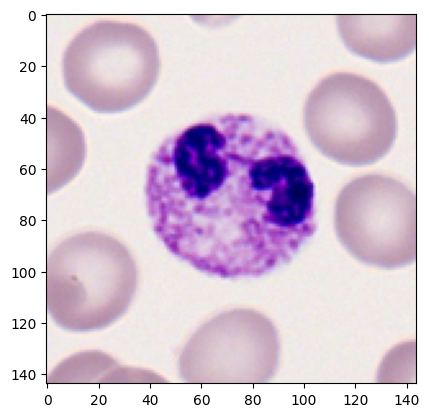

In [ ]:
plt.imshow(train_images[0])

# Code adaptation


Title: Data-efficient GANs with Adaptive Discriminator Augmentation
Author: [András Béres](https://www.linkedin.com/in/andras-beres-789190210)
Date created: 2021/10/28
Last modified: 2021/10/28
Description: Generating images from limited data using the Caltech Birds dataset.
Accelerator: GPU


## Introduction

### GANs

[Generative Adversarial Networks (GANs)](https://arxiv.org/abs/1406.2661) are a popular
class of generative deep learning models, commonly used for image generation. They
consist of a pair of dueling neural networks, called the discriminator and the generator.
The discriminator's task is to distinguish real images from generated (fake) ones, while
the generator network tries to fool the discriminator by generating more and more
realistic images. If the generator is however too easy or too hard to fool, it might fail
to provide useful learning signal for the generator, therefore training GANs is usually
considered a difficult task.

### Data augmentation for GANS

Data augmentation, a popular technique in deep learning, is the process of randomly
applying semantics-preserving transformations to the input data to generate multiple
realistic versions of it, thereby effectively multiplying the amount of training data
available. The simplest example is left-right flipping an image, which preserves its
contents while generating a second unique training sample. Data augmentation is commonly
used in supervised learning to prevent overfitting and enhance generalization.

The authors of [StyleGAN2-ADA](https://arxiv.org/abs/2006.06676) show that discriminator
overfitting can be an issue in GANs, especially when only low amounts of training data is
available. They propose Adaptive Discriminator Augmentation to mitigate this issue.

Applying data augmentation to GANs however is not straightforward. Since the generator is
updated using the discriminator's gradients, if the generated images are augmented, the
augmentation pipeline has to be differentiable and also has to be GPU-compatible for
computational efficiency. Luckily, the
[Keras image augmentation layers](https://keras.io/api/layers/preprocessing_layers/image_augmentation/)
fulfill both these requirements, and are therefore very well suited for this task.

### Invertible data augmentation

A possible difficulty when using data augmentation in generative models is the issue of
["leaky augmentations" (section 2.2)](https://arxiv.org/abs/2006.06676), namely when the
model generates images that are already augmented. This would mean that it was not able
to separate the augmentation from the underlying data distribution, which can be caused
by using non-invertible data transformations. For example, if either 0, 90, 180 or 270
degree rotations are performed with equal probability, the original orientation of the
images is impossible to infer, and this information is destroyed.

A simple trick to make data augmentations invertible is to only apply them with some
probability. That way the original version of the images will be more common, and the
data distribution can be infered. By properly choosing this probability, one can
effectively regularize the discriminator without making the augmentations leaky.




In [ ]:


## Setup


import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers



## Hyperparameterers

In [ ]:


# data
num_epochs = 1000  # train for 400 epochs for good results
image_size = 144
# resolution of Kernel Inception Distance measurement, see related section
kid_image_size = 75
padding = 0.25
dataset_name = "caltech_birds2011"
num_channels = 3

# adaptive discriminator augmentation
max_translation = 0.125
max_rotation = 0.125
max_zoom = 0.25
target_accuracy = 0.85
integration_steps = 1000

# architecture
noise_size = 64
depth = 4
# width is latent_dim
width = 128
leaky_relu_slope = 0.2
dropout_rate = 0.4

# optimization
batch_size = 128
learning_rate = 2e-4
beta_1 = 0.5  # not using the default value of 0.9 is important
ema = 0.99


In [ ]:



def round_to_int(float_value):
    return tf.cast(tf.math.round(float_value), dtype=tf.int32)


def preprocess_image(data):
    # unnormalize bounding box coordinates
    height = tf.cast(tf.shape(data["image"])[0], dtype=tf.float32)
    width = tf.cast(tf.shape(data["image"])[1], dtype=tf.float32)
    bounding_box = data["bbox"] * tf.stack([height, width, height, width])

    # calculate center and length of longer side, add padding
    target_center_y = 0.5 * (bounding_box[0] + bounding_box[2])
    target_center_x = 0.5 * (bounding_box[1] + bounding_box[3])
    target_size = tf.maximum(
        (1.0 + padding) * (bounding_box[2] - bounding_box[0]),
        (1.0 + padding) * (bounding_box[3] - bounding_box[1]),
    )

    # modify crop size to fit into image
    target_height = tf.reduce_min(
        [target_size, 2.0 * target_center_y, 2.0 * (height - target_center_y)]
    )
    target_width = tf.reduce_min(
        [target_size, 2.0 * target_center_x, 2.0 * (width - target_center_x)]
    )

    # crop image
    image = tf.image.crop_to_bounding_box(
        data["image"],
        offset_height=round_to_int(target_center_y - 0.5 * target_height),
        offset_width=round_to_int(target_center_x - 0.5 * target_width),
        target_height=round_to_int(target_height),
        target_width=round_to_int(target_width),
    )

    # resize and clip
    # for image downsampling, area interpolation is the preferred method
    image = tf.image.resize(
        image, size=[image_size, image_size], method=tf.image.ResizeMethod.AREA
    )
    return tf.clip_by_value(image / 255.0, 0.0, 1.0)


def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID calculation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


# birds_train_dataset = prepare_dataset("train")
# birds_val_dataset = prepare_dataset("test")


In [ ]:
print(train_dataset)
# print(birds_train_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(128, 144, 144, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 15), dtype=tf.float32, name=None))>


In [ ]:
print(len(train_dataset.as_numpy_iterator().next()[0]))
# print(len(birds_train_dataset.as_numpy_iterator().next()))

128


## Data pipeline

In this example, we will use the
[Caltech Birds (2011)](https://www.tensorflow.org/datasets/catalog/caltech_birds2011) dataset for
generating images of birds, which is a diverse natural dataset containing less then 6000
images for training. When working with such low amounts of data, one has to take extra
care to retain as high data quality as possible. In this example, we use the provided
bounding boxes of the birds to cut them out with square crops while preserving their
aspect ratios when possible.



After preprocessing the training images look like the following:
![birds dataset](https://i.imgur.com/Ru5HgBM.png)



## Kernel inception distance

[Kernel Inception Distance (KID)](https://arxiv.org/abs/1801.01401) was proposed as a
replacement for the popular
[Frechet Inception Distance (FID)](https://arxiv.org/abs/1706.08500)
metric for measuring image generation quality.
Both metrics measure the difference in the generated and training distributions in the
representation space of an [InceptionV3](https://keras.io/api/applications/inceptionv3/)
network pretrained on
[ImageNet](https://www.tensorflow.org/datasets/catalog/imagenet2012).

According to the paper, KID was proposed because FID has no unbiased estimator, its
expected value is higher when it is measured on fewer images. KID is more suitable for
small datasets because its expected value does not depend on the number of samples it is
measured on. In my experience it is also computationally lighter, numerically more
stable, and simpler to implement because it can be estimated in a per-batch manner.

In this example, the images are evaluated at the minimal possible resolution of the
Inception network (75x75 instead of 299x299), and the metric is only measured on the
validation set for computational efficiency.




In [ ]:



class KID(keras.metrics.Metric):
    def __init__(self, name="kid", **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean()

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                layers.InputLayer(input_shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()






## Adaptive discriminator augmentation

The authors of [StyleGAN2-ADA](https://arxiv.org/abs/2006.06676) propose to change the
augmentation probability adaptively during training. Though it is explained differently
in the paper, they use [integral control](https://en.wikipedia.org/wiki/PID_controller#Integral) on the augmentation
probability to keep the discriminator's accuracy on real images close to a target value.
Note, that their controlled variable is actually the average sign of the discriminator
logits (r_t in the paper), which corresponds to 2 * accuracy - 1.

This method requires two hyperparameters:

1. `target_accuracy`: the target value for the discriminator's accuracy on real images. I
recommend selecting its value from the 80-90% range.
2. [`integration_steps`](https://en.wikipedia.org/wiki/PID_controller#Mathematical_form):
the number of update steps required for an accuracy error of 100% to transform into an
augmentation probability increase of 100%. To give an intuition, this defines how slowly
the augmentation probability is changed. I recommend setting this to a relatively high
value (1000 in this case) so that the augmentation strength is only adjusted slowly.

The main motivation for this procedure is that the optimal value of the target accuracy
is similar across different dataset sizes (see [figure 4 and 5 in the paper](https://arxiv.org/abs/2006.06676)),
so it does not have to be retuned, because the
process automatically applies stronger data augmentation when it is needed.



In [ ]:



# "hard sigmoid", useful for binary accuracy calculation from logits
def step(values):
    # negative values -> 0.0, positive values -> 1.0
    return 0.5 * (1.0 + tf.sign(values))


# augments images with a probability that is dynamically updated during training
class AdaptiveAugmenter(keras.Model):
    def __init__(self):
        super().__init__()

        # stores the current probability of an image being augmented
        self.probability = tf.Variable(0.0)

        # the corresponding augmentation names from the paper are shown above each layer
        # the authors show (see figure 4), that the blitting and geometric augmentations
        # are the most helpful in the low-data regime
        self.augmenter = keras.Sequential(
            [
                layers.InputLayer(input_shape=(image_size, image_size, 3)),
                # blitting/x-flip:
                layers.RandomFlip("horizontal"),
                # blitting/integer translation:
                layers.RandomTranslation(
                    height_factor=max_translation,
                    width_factor=max_translation,
                    interpolation="nearest",
                ),
                # geometric/rotation:
                layers.RandomRotation(factor=max_rotation),
                # geometric/isotropic and anisotropic scaling:
                layers.RandomZoom(
                    height_factor=(-max_zoom, 0.0), width_factor=(-max_zoom, 0.0)
                ),
            ],
            name="adaptive_augmenter",
        )

    def call(self, images, training):
        if training:
            augmented_images = self.augmenter(images, training)

            # during training either the original or the augmented images are selected
            # based on self.probability
            augmentation_values = tf.random.uniform(
                shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
            )
            augmentation_bools = tf.math.less(augmentation_values, self.probability)

            images = tf.where(augmentation_bools, augmented_images, images)
        return images

    def update(self, real_logits):
        current_accuracy = tf.reduce_mean(step(real_logits))

        # the augmentation probability is updated based on the dicriminator's
        # accuracy on real images
        accuracy_error = current_accuracy - target_accuracy
        self.probability.assign(
            tf.clip_by_value(
                self.probability + accuracy_error / integration_steps, 0.0, 1.0
            )
        )





## Network architecture

Here we specify the architecture of the two networks:

* generator: maps a random vector to an image, which should be as realistic as possible
* discriminator: maps an image to a scalar score, which should be high for real and low
for generated images

GANs tend to be sensitive to the network architecture, I implemented a DCGAN architecture
in this example, because it is relatively stable during training while being simple to
implement. We use a constant number of filters throughout the network, use a sigmoid
instead of tanh in the last layer of the generator, and use default initialization
instead of random normal as further simplifications.

As a good practice, we disable the learnable scale parameter in the batch normalization
layers, because on one hand the following relu + convolutional layers make it redundant
(as noted in the
[documentation](https://keras.io/api/layers/normalization_layers/batch_normalization/)).
But also because it should be disabled based on theory when using [spectral normalization
(section 4.1)](https://arxiv.org/abs/1802.05957), which is not used here, but is common
in GANs. We also disable the bias in the fully connected and convolutional layers, because
the following batch normalization makes it redundant.


In [ ]:
generator_in_channels = noise_size + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

79 18


In [ ]:



# DCGAN generator
def get_generator():
    noise_input = keras.Input(shape=(generator_in_channels,))
    # Changed from 4 * 4 * width to 9 * 9 * width to fit the 144x144 image output
    x = layers.Dense(9 * 9 * generator_in_channels, use_bias=False)(noise_input)
    x = layers.BatchNormalization(scale=False)(x)
    x = layers.ReLU()(x)
    x = layers.Reshape(target_shape=(9, 9, generator_in_channels))(x)
    for _ in range(depth - 1):
        x = layers.Conv2DTranspose(
            width,
            kernel_size=4,
            strides=2,
            padding="same",
            use_bias=False,
        )(x)
        x = layers.BatchNormalization(scale=False)(x)
        x = layers.ReLU()(x)
    image_output = layers.Conv2DTranspose(
        3,
        kernel_size=4,
        strides=2,
        padding="same",
        activation="sigmoid",
    )(x)

    return keras.Model(noise_input, image_output, name="generator")


# DCGAN discriminator
def get_discriminator():
    image_input = keras.Input(shape=(image_size, image_size, discriminator_in_channels))
    x = image_input
    for _ in range(depth):
        x = layers.Conv2D(
            width,
            kernel_size=4,
            strides=2,
            padding="same",
            use_bias=False,
        )(x)
        x = layers.BatchNormalization(scale=False)(x)
        x = layers.LeakyReLU(alpha=leaky_relu_slope)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    output_score = layers.Dense(1)(x)
    return keras.Model(image_input, output_score, name="discriminator")



## GAN model

In [ ]:



class GAN_ADA(keras.Model):
    def __init__(self):
        super().__init__()

        self.augmenter = AdaptiveAugmenter()
        self.generator = get_generator()
        self.ema_generator = keras.models.clone_model(self.generator)
        self.discriminator = get_discriminator()

        self.generator.summary()
        self.discriminator.summary()

    # # ---------------------------------------------------------------------------------------------------------
    # def get_config(self):
    #     config = super().get_config()
    #     return config
    # def call(self, inputs):
    #     # Define the forward pass of the model
    #     # Perform any necessary computations and return the output
    #     # Make sure to invoke the forward pass using `self.__call__(inputs)` instead of `self.call(inputs)`
    #     return self.__call__(inputs)
    # # ---------------------------------------------------------------------------------------------------------

    def compile(self, generator_optimizer, discriminator_optimizer, **kwargs):
        super().compile(**kwargs)

        # separate optimizers for the two networks
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

        self.generator_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.discriminator_loss_tracker = keras.metrics.Mean(name="d_loss")
        self.real_accuracy = keras.metrics.BinaryAccuracy(name="real_acc")
        self.generated_accuracy = keras.metrics.BinaryAccuracy(name="gen_acc")
        self.augmentation_probability_tracker = keras.metrics.Mean(name="aug_p")
        self.kid = KID()

    @property
    def metrics(self):
        return [
            self.generator_loss_tracker,
            self.discriminator_loss_tracker,
            self.real_accuracy,
            self.generated_accuracy,
            self.augmentation_probability_tracker,
            self.kid,
        ]

    def generate(self, batch_size, one_hot_labels, training):

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        random_latent_vectors = tf.random.normal(shape=(batch_size, noise_size))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # use ema_generator during inference
        if training:
            generated_images = self.generator(random_vector_labels, training)
        else:
            generated_images = self.ema_generator(random_vector_labels, training)
        return generated_images

    def adversarial_loss(self, real_logits, generated_logits):
        # this is usually called the non-saturating GAN loss

        real_labels = tf.ones(shape=(batch_size, 1))
        generated_labels = tf.zeros(shape=(batch_size, 1))

        # the generator tries to produce images that the discriminator considers as real
        generator_loss = keras.losses.binary_crossentropy(
            real_labels, generated_logits, from_logits=True
        )
        # the discriminator tries to determine if images are real or generated
        discriminator_loss = keras.losses.binary_crossentropy(
            tf.concat([real_labels, generated_labels], axis=0),
            tf.concat([real_logits, generated_logits], axis=0),
            from_logits=True,
        )

        return tf.reduce_mean(generator_loss), tf.reduce_mean(discriminator_loss)

    def train_step(self, data):
        real_images, one_hot_labels = data
        print(f"data: {data}\nreal_images: {real_images}\none_hot_labels: {one_hot_labels}")
        real_images = self.augmenter(real_images, training=True)

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # use persistent gradient tape because gradients will be calculated twice
        with tf.GradientTape(persistent=True) as tape:
            generated_images = self.generate(batch_size, one_hot_labels, training=True)
            # gradient is calculated through the image augmentation
            generated_images = self.augmenter(generated_images, training=True)

            # Combine them with real images. Note that we are concatenating the labels
            # with these images here.
            fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
            real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
            combined_images = tf.concat(
                [fake_image_and_labels, real_image_and_labels], axis=0
            )

            # separate forward passes for the real and generated images, meaning
            # that batch normalization is applied separately
            real_logits = self.discriminator(real_image_and_labels, training=True)
            generated_logits = self.discriminator(fake_image_and_labels, training=True)

            generator_loss, discriminator_loss = self.adversarial_loss(
                real_logits, generated_logits
            )

        # calculate gradients and update weights
        generator_gradients = tape.gradient(
            generator_loss, self.generator.trainable_weights
        )
        discriminator_gradients = tape.gradient(
            discriminator_loss, self.discriminator.trainable_weights
        )
        self.generator_optimizer.apply_gradients(
            zip(generator_gradients, self.generator.trainable_weights)
        )
        self.discriminator_optimizer.apply_gradients(
            zip(discriminator_gradients, self.discriminator.trainable_weights)
        )

        # update the augmentation probability based on the discriminator's performance
        self.augmenter.update(real_logits)

        self.generator_loss_tracker.update_state(generator_loss)
        self.discriminator_loss_tracker.update_state(discriminator_loss)
        self.real_accuracy.update_state(1.0, step(real_logits))
        self.generated_accuracy.update_state(0.0, step(generated_logits))
        self.augmentation_probability_tracker.update_state(self.augmenter.probability)

        # track the exponential moving average of the generator's weights to decrease
        # variance in the generation quality
        for weight, ema_weight in zip(
            self.generator.weights, self.ema_generator.weights
        ):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}



    def test_step(self, data):
        real_images, one_hot_labels = data
        generated_images = self.generate(batch_size, one_hot_labels, training=False)

        self.kid.update_state(real_images, generated_images)

        # only KID is measured during the evaluation phase for computational efficiency
        return {self.kid.name: self.kid.result()}

    def plot_images(self, epoch=None, logs=None, num_rows=4, num_cols=4, interval=5):
        # plot random generated images for visual evaluation of generation quality
        if epoch is None or (epoch + 1) % interval == 0:
            num_images = num_classes
            # random_labels = [random.randint(0, num_classes-1) for _ in range(num_images)]
            labels = [l for l in range(num_classes)]
            one_hot_labels = [to_categorical(label, num_classes) for label in labels]

            generated_images = self.generate(num_images, one_hot_labels, training=False)

            plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
            for row in range(num_rows):
                for col in range(num_cols):
                    index = row * num_cols + col
                    if (index >= num_classes): break
                    plt.subplot(num_rows, num_cols, index + 1)
                    plt.imshow(generated_images[index])
                    label_code = labels[index]
                    plt.text(0, -10, f"{CODE_TO_LABEL[label_code]} [{label_code}]", ha='center')
                    plt.axis("off")
            plt.tight_layout()
            plt.show()
            plt.close()



## Training

One can should see from the metrics during training, that if the real accuracy
(discriminator's accuracy on real images) is below the target accuracy, the augmentation
probability is increased, and vice versa. In my experience, during a healthy GAN
training, the discriminator accuracy should stay in the 80-95% range. Below that, the
discriminator is too weak, above that it is too strong.

Note that we track the exponential moving average of the generator's weights, and use that
for image generation and KID evaluation.


In [ ]:


# create and compile the model
model = GAN_ADA()
model.compile(
    generator_optimizer=keras.optimizers.Adam(learning_rate, beta_1),
    discriminator_optimizer=keras.optimizers.Adam(learning_rate, beta_1),
)

# # save the best model based on the validation KID metric
checkpoint_path = os.path.join(ADA_MODEL_PATH,"gan_model")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)



Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 79)]              0         
                                                                 
 dense (Dense)               (None, 6399)              505521    
                                                                 
 batch_normalization (BatchN  (None, 6399)             19197     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 6399)              0         
                                                                 
 reshape (Reshape)           (None, 9, 9, 79)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 18, 18, 128)      161792    
 nspose)                                                 

In [31]:
# run training and plot generated images periodically

r = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        checkpoint_callback,
    ],
)

Output hidden; open in https://colab.research.google.com to view.


## Inference

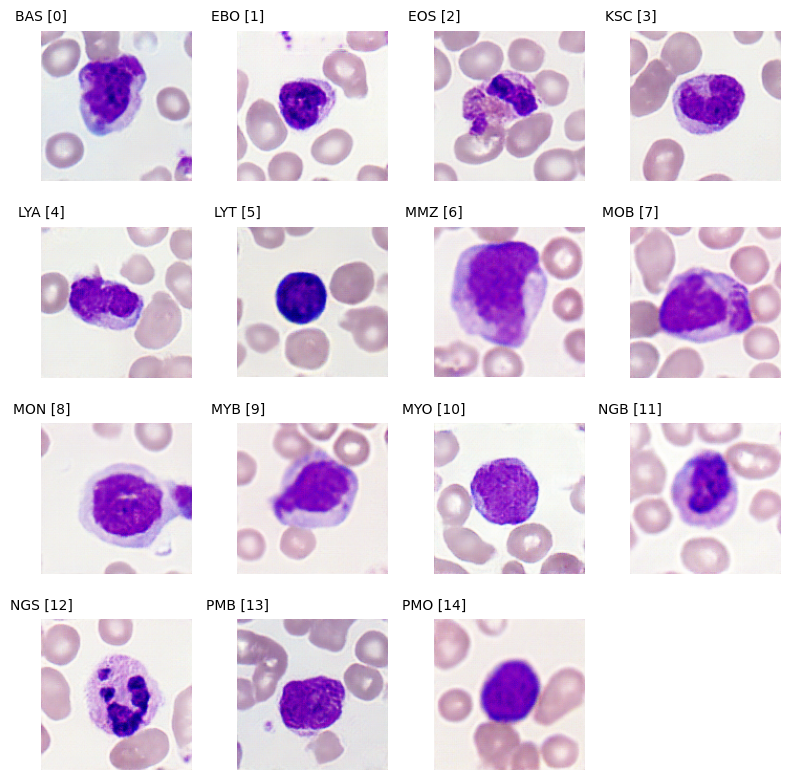

In [32]:
# load the best model and generate images
model.load_weights(checkpoint_path)
model.plot_images()


In [33]:
if(not os.path.exists(ADA_TRAIN_DATA_PATH)): os.mkdir(ADA_TRAIN_DATA_PATH)

r_name = 'history.pickle'
r_save_path = os.path.join(ADA_TRAIN_DATA_PATH, r_name)


In [34]:
with open(r_save_path, 'rb') as f:
    model_history = pickle.load(f)

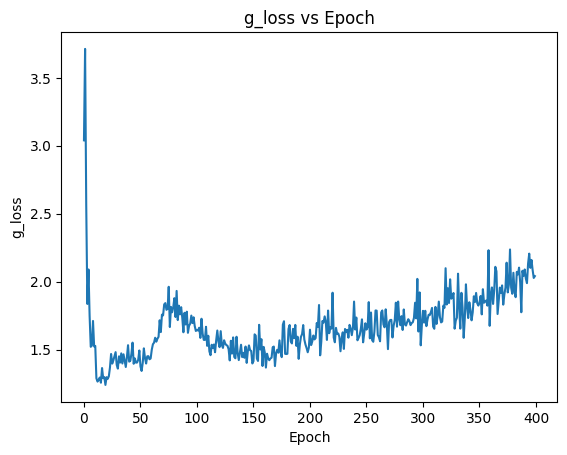

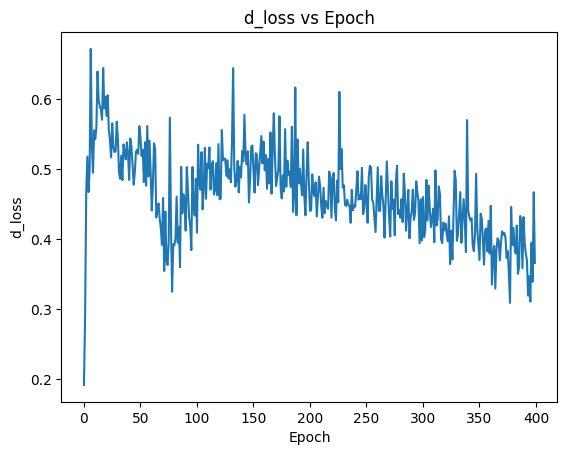

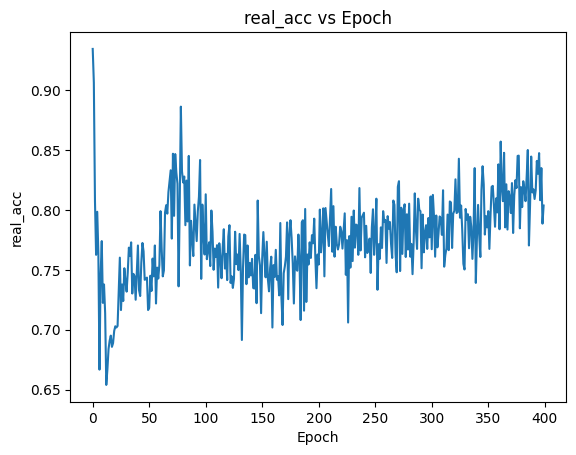

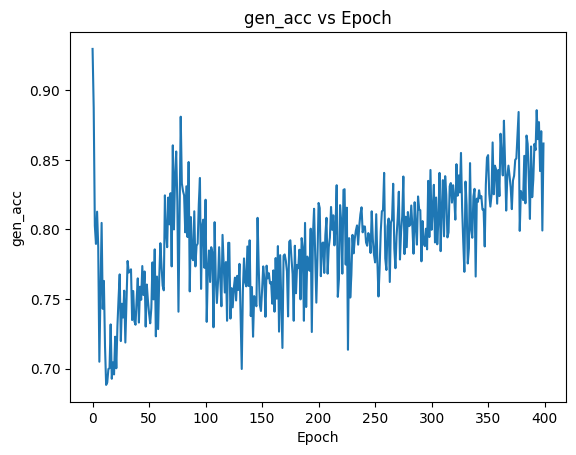

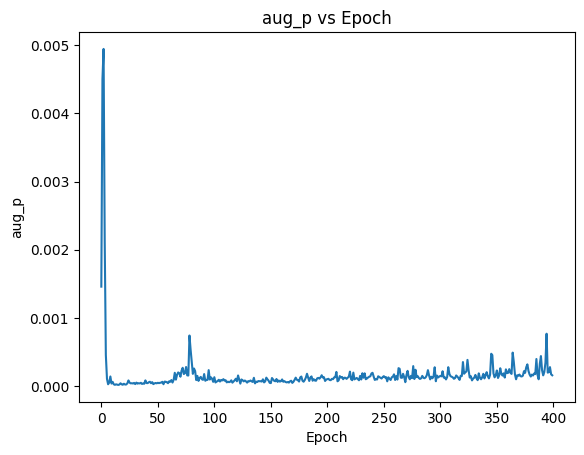

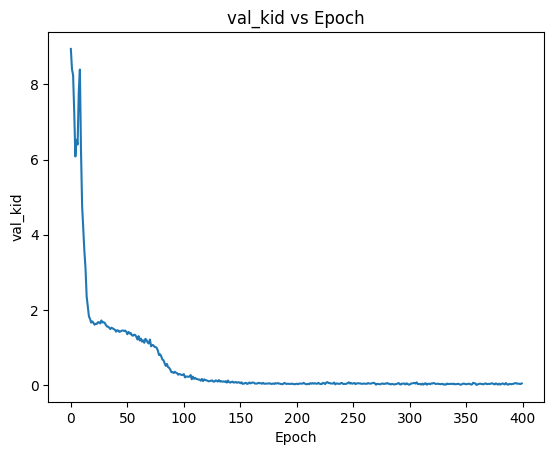

In [35]:
# Get the metrics from the model history
metrics = list(model_history.keys())

# Plot each metric
for metric in metrics:
    # Get the metric values
    values = model_history[metric]

    # Create the plot
    plt.plot(values)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(f'{metric} vs Epoch')
    plt.show()

In [36]:
with open(r_save_path, 'wb') as handle:
    pickle.dump(r.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
# Delete the runtime at the end of the execution
if(DELETE_RUNTIME_AT_END): runtime.unassign()



## Results

By running the training for 400 epochs (which takes 2-3 hours in a Colab notebook), one
can get high quality image generations using this code example.

The evolution of a random batch of images over a 400 epoch training (ema=0.999 for
animation smoothness):
![birds evolution gif](https://i.imgur.com/ecGuCcz.gif)

Latent-space interpolation between a batch of selected images:
![birds interpolation gif](https://i.imgur.com/nGvzlsC.gif)

I also recommend trying out training on other datasets, such as
[CelebA](https://www.tensorflow.org/datasets/catalog/celeb_a) for example. In my
experience good results can be achieved without changing any hyperparameters (though
discriminator augmentation might not be necessary).

## GAN tips and tricks

My goal with this example was to find a good tradeoff between ease of implementation and
generation quality for GANs. During preparation I have run numerous ablations using
[this repository](https://github.com/beresandras/gan-flavours-keras).

In this section I list the lessons learned and my recommendations in my subjective order
of importance.

I recommend checking out the [DCGAN paper](https://arxiv.org/abs/1511.06434), this
[NeurIPS talk](https://www.youtube.com/watch?v=myGAju4L7O8), and this
[large scale GAN study](https://arxiv.org/abs/1711.10337) for others' takes on this subject.

### Architectural tips

* **resolution**: Training GANs at higher resolutions tends to get more difficult, I
recommend experimenting at 32x32 or 64x64 resolutions initially.
* **initialization**: If you see strong colorful patterns early on in the training, the
initalization might be the issue. Set the kernel_initializer parameters of layers to
[random normal](https://keras.io/api/layers/initializers/#randomnormal-class), and
decrease the standard deviation (recommended value: 0.02, following DCGAN) until the
issue disappears.
* **upsampling**: There are two main methods for upsampling in the generator.
[Transposed convolution](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/)
is faster, but can lead to
[checkerboard artifacts](https://distill.pub/2016/deconv-checkerboard/), which can be reduced by using
a kernel size that is divisible with the stride (recommended kernel size is 4 for a stride of 2).
[Upsampling](https://keras.io/api/layers/reshaping_layers/up_sampling2d/) +
[standard convolution](https://keras.io/api/layers/convolution_layers/convolution2d/) can have slightly
lower quality, but checkerboard artifacts are not an issue. I recommend using nearest-neighbor
interpolation over bilinear for it.
* **batch normalization in discriminator**: Sometimes has a high impact, I recommend
trying out both ways.
* **[spectral normalization](https://www.tensorflow.org/addons/api_docs/python/tfa/layers/SpectralNormalization)**:
A popular technique for training GANs, can help with stability. I recommend
disabling batch normalization's learnable scale parameters along with it.
* **[residual connections](https://keras.io/guides/functional_api/#a-toy-resnet-model)**:
While residual discriminators behave similarly, residual generators are more difficult to
train in my experience. They are however necessary for training large and deep
architectures. I recommend starting with non-resiudal architectures.
* **dropout**: Using dropout before the last layer of the discriminator improves
generation quality in my experience. Recommended dropout rate is below 0.5.
* **[leaky ReLU](https://keras.io/api/layers/activation_layers/leaky_relu/)**: Use leaky
ReLU activations in the discriminator to make its gradients less sparse. Recommended
slope/alpha is 0.2 following DCGAN.

### Algorithmic tips

* **loss functions**: Numerous losses have been proposed over the years for training
GANs, promising improved performance and stability. I have implemented 5 of them in
[this repository](https://github.com/beresandras/gan-flavours-keras), and my experience is in
line with [this GAN study](https://arxiv.org/abs/1711.10337): no loss seems to
consistently outperform the default non-saturating GAN loss. I recommend using that as a
default.
* **Adam's beta_1 parameter**: The beta_1 parameter in Adam can be interpreted as the
momentum of mean gradient estimation. Using 0.5 or even 0.0 instead of the default 0.9
value was proposed in DCGAN and is important. This example would not work using its
default value.
* **separate batch normalization for generated and real images**: The forward pass of the
discriminator should be separate for the generated and real images. Doing otherwise can
lead to artifacts (45 degree stripes in my case) and decreased performance.
* **exponential moving average of generator's weights**: This helps to reduce the
variance of the KID measurement, and helps in averaging out the rapid color palette
changes during training.
* **[different learning rate for generator and discriminator](https://arxiv.org/abs/1706.08500)**:
If one has the resources, it can help
to tune the learning rates of the two networks separately. A similar idea is to update
either network's (usually the discriminator's) weights multiple times for each of the
other network's updates. I recommend using the same learning rate of 2e-4 (Adam),
following DCGAN for both networks, and only updating both of them once as a default.
* **label noise**: [One-sided label smoothing](https://arxiv.org/abs/1606.03498) (using
less than 1.0 for real labels), or adding noise to the labels can regularize the
discriminator not to get overconfident, however in my case they did not improve
performance.
* **adaptive data augmentation**: Since it adds another dynamic component to the training
process, disable it as a default, and only enable it when the other components already
work well.



## Related works

Other GAN-related Keras code examples:

* [DCGAN + CelebA](https://keras.io/examples/generative/dcgan_overriding_train_step/)
* [WGAN + FashionMNIST](https://keras.io/examples/generative/wgan_gp/)
* [WGAN + Molecules](https://keras.io/examples/generative/wgan-graphs/)
* [ConditionalGAN + MNIST](https://keras.io/examples/generative/conditional_gan/)
* [CycleGAN + Horse2Zebra](https://keras.io/examples/generative/cyclegan/)
* [StyleGAN](https://keras.io/examples/generative/stylegan/)

Modern GAN architecture-lines:

* [SAGAN](https://arxiv.org/abs/1805.08318), [BigGAN](https://arxiv.org/abs/1809.11096)
* [ProgressiveGAN](https://arxiv.org/abs/1710.10196),
[StyleGAN](https://arxiv.org/abs/1812.04948),
[StyleGAN2](https://arxiv.org/abs/1912.04958),
[StyleGAN2-ADA](https://arxiv.org/abs/2006.06676),
[AliasFreeGAN](https://arxiv.org/abs/2106.12423)

Concurrent papers on discriminator data augmentation:
[1](https://arxiv.org/abs/2006.02595), [2](https://arxiv.org/abs/2006.05338), [3](https://arxiv.org/abs/2006.10738)

Recent literature overview on GANs: [talk](https://www.youtube.com/watch?v=3ktD752xq5k)
